# Read Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import random
import math
import statistics as stat
from scipy import stats

In [18]:
data = pd.read_csv('/content/drive/MyDrive/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# PreProcessing

In [19]:
y = data['target']

In [20]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.drop(columns='target'))
data_scaled

array([[0.70833333, 1.        , 1.        , ..., 0.        , 0.        ,
        0.33333333],
       [0.16666667, 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.66666667],
       [0.25      , 0.        , 0.33333333, ..., 1.        , 0.        ,
        0.66666667],
       ...,
       [0.8125    , 1.        , 0.        , ..., 0.5       , 0.5       ,
        1.        ],
       [0.58333333, 1.        , 0.        , ..., 0.5       , 0.25      ,
        1.        ],
       [0.58333333, 0.        , 0.33333333, ..., 0.5       , 0.25      ,
        0.66666667]])

In [22]:
data = pd.DataFrame(data_scaled,index= data.index,columns=data.drop(columns='target').columns)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.333333
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.0,0.666667
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,0.666667
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.0,0.666667
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.0,0.666667


In [23]:
X = data[['chol','trestbps','thalach']]

In [24]:
X.head()

,chol,trestbps,thalach
0,0.244292,0.481132,0.603053
1,0.283105,0.339623,0.885496
2,0.178082,0.339623,0.770992
3,0.251142,0.245283,0.816794
4,0.520548,0.245283,0.702290


In [25]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GNB

without package

In [27]:
# gaussClf will be the class that will have the Gaussian naive bayes classifier implimentation
class gaussClf:
    def separate_by_classes(self, X, y):
        ''' This function separates our dataset in subdatasets by classes '''
        self.classes = np.unique(y)
        classes_index = {}
        subdatasets = {}
        cls, counts = np.unique(y, return_counts=True)
        self.class_freq = dict(zip(cls, counts))
        print(self.class_freq)
        for class_type in self.classes:
            classes_index[class_type] = np.argwhere(y==class_type)
            subdatasets[class_type] = X[classes_index[class_type], :]
            self.class_freq[class_type] = self.class_freq[class_type]/sum(list(self.class_freq.values()))
        return subdatasets

    def fit(self, X, y):
        ''' The fitting function '''
        separated_X = self.separate_by_classes(X, y)
        self.means = {}
        self.std = {}
        for class_type in self.classes:
            # Here we calculate the mean and the standart deviation from datasets
            self.means[class_type] = np.mean(separated_X[class_type], axis=0)[0]
            self.std[class_type] = np.std(separated_X[class_type], axis=0)[0] 

    def calculate_probability(self, x, mean, stdev):
        ''' This function calculates the class probability using gaussian distribution '''
        exponent = math.exp(-((x - mean) ** 2 / (2 * stdev ** 2)))
        return (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent

    def predict_proba(self, X):
        ''' This function predicts the probability for every class '''
        self.class_prob = {cls:math.log(self.class_freq[cls], math.e) for cls in self.classes}
        for cls in self.classes:
            for i in range(len(self.means)):
                print(X[i])
                self.class_prob[cls]+=math.log(self.calculate_probability(X[i], self.means[cls][i], self.std[cls][i]), math.e)
        self.class_prob = {cls: math.e**self.class_prob[cls] for cls in self.class_prob}
        return self.class_prob

    def predict(self, X):
        ''' This funtion predicts the class of a sample '''
        pred = []
        for x in X:
            pred_class = None
            max_prob = 0
            for cls, prob in self.predict_proba(x).items():
                if prob>max_prob:
                    max_prob = prob
                    pred_class = cls
            pred.append(pred_class)
        return pred

In [28]:
gnb = gaussClf()
gnb.fit(X_train.to_numpy(),y_train.to_numpy())

{0: 109, 1: 133}


In [31]:
y_predict = gnb.predict(X_test.to_numpy())

0.3424657534246575
0.5283018867924528
0.3424657534246575
0.5283018867924528
0.3698630136986301
0.7169811320754716
0.3698630136986301
0.7169811320754716
0.0
0.5283018867924528
0.0
0.5283018867924528
0.6461187214611872
0.37735849056603776
0.6461187214611872
0.37735849056603776
0.31735159817351594
0.15094339622641517
0.31735159817351594
0.15094339622641517
0.0958904109589041
0.5283018867924528
0.0958904109589041
0.5283018867924528
0.2671232876712329
0.41509433962264153
0.2671232876712329
0.41509433962264153
0.3698630136986301
1.0
0.3698630136986301
1.0
0.36529680365296807
0.26415094339622647
0.36529680365296807
0.26415094339622647
0.33561643835616434
0.2924528301886792
0.33561643835616434
0.2924528301886792
0.1506849315068493
0.4339622641509434
0.1506849315068493
0.4339622641509434
0.32876712328767127
0.7924528301886792
0.32876712328767127
0.7924528301886792
0.45433789954337894
0.24528301886792458
0.45433789954337894
0.24528301886792458
0.09360730593607308
0.15094339622641517
0.0936073059

In [45]:
import sklearn.metrics as mt
mt.accuracy_score(y_test,y_predict)

0.5901639344262295

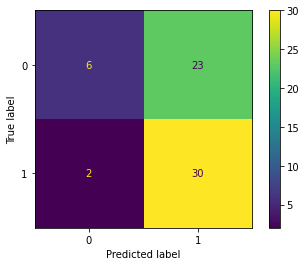

In [47]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [48]:
mt.f1_score(y_test,y_predict)

0.7058823529411765

In [51]:
mt.precision_score(y_test,y_predict)

0.5660377358490566

In [52]:
mt.recall_score(y_test,y_predict)

0.9375

with package

In [55]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [56]:
y_predict = gnb.predict(X_test)

In [57]:
import sklearn.metrics as mt
mt.accuracy_score(y_test,y_predict)

0.7540983606557377

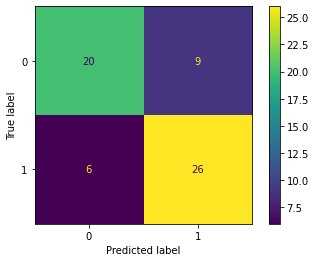

In [58]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [59]:
mt.f1_score(y_test,y_predict)

0.7761194029850748

In [60]:
mt.precision_score(y_test,y_predict)

0.7428571428571429

In [61]:
mt.recall_score(y_test,y_predict)

0.8125